# Analyse Relation Loss

In [84]:
ORIG_TRAIN_FILE = "./data/datasets/docred/train_annotated.json"
PERT_TRAIN_FILE = "./data/datasets/docred/train_annotated_perturbed.json"
REMOVED_RELS_FILE = "./data/datasets/docred/train_annotated_removed_rels.json"

REL_LOSS_FILES = {
    "ckpt0": "./influence_analysis/scores/rel_loss_perturbed_ckpt0.jsonl",
    "ckpt5": "./influence_analysis/scores/rel_loss_perturbed_ckpt5.jsonl",
    "ckpt10": "./influence_analysis/scores/rel_loss_perturbed_ckpt10.jsonl",
    "ckpt15": "./influence_analysis/scores/rel_loss_perturbed_ckpt15.jsonl",
    "ckpt19": "./influence_analysis/scores/rel_loss_perturbed_ckpt19.jsonl",
}

In [85]:
import jsonlines
import json
from copy import copy
import matplotlib.pyplot as plt

In [86]:
with open(ORIG_TRAIN_FILE, "r") as fd:
    orig_data = json.load(fd)

with open(REMOVED_RELS_FILE, "r") as fd:
    removed_rels = json.load(fd)

In [87]:
# Computed contants
REMOVED_RELS_COUNT = sum(len(r) for r in removed_rels)

with jsonlines.open(REL_LOSS_FILES['ckpt0']) as rel_loss_reader:
    TOTAL_ENT_PAIRS = sum(len(p) for p in rel_loss_reader)

In [88]:
# Some util functions

def is_perturbed(rel):
    doc_id = rel['doc_id']
    head_ent, tail_ent = rel['entity_pair']
    doc = removed_rels[doc_id]
    
    for r in doc:
        if r['h'] == head_ent and r['t'] == tail_ent:
            return True
    
    return False

In [89]:
def gen_plot_precision(rels, hit_fn, total, label, plot):
    x = [float(i) for i, _ in enumerate(rels)]
    y = []

    found = 0.
    for rel in rels:
        if hit_fn(rel):
            found += 1
        y.append(found / total)

    if plot is None:
        plt.xlabel("n (checked samples)")
        plt.ylabel("recall")
        y_perf = [float(i+1) / total if i+1 < total else 1 for i, _ in enumerate(rels)]
        plt.plot(x, y_perf, label="perfect")
        plt.legend()
    
    plt.plot(x, y, label=label)
    return plt

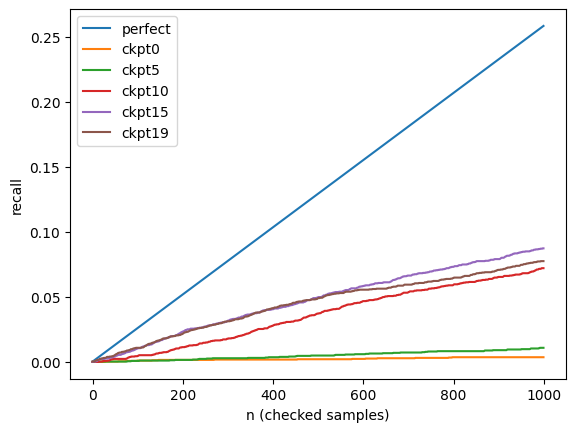

In [92]:

plot = None

for label, file in REL_LOSS_FILES.items():
    rel_loss = []
    
    with jsonlines.open(file) as rel_loss_reader:
        for doc_id, data in enumerate(rel_loss_reader):
            for rel in data:
                entry = copy(rel)
                entry['doc_id'] = doc_id
                rel_loss.append(entry)

    sorted_by_rel_loss = sorted(rel_loss, key=lambda d: d['loss'], reverse=True)
    plot = gen_plot_precision(sorted_by_rel_loss[:1000], is_perturbed, REMOVED_RELS_COUNT, label, plot)

plt.legend()
plt.draw()
plt.savefig("rel_loss_recall")